In [ ]:
!pip install pyod
!pip install networkx
!pip install torch torch-geometric

In [2]:
# donwload datasets used
! gdown 1XMSE2TIMP1LsX-AyYICfR6XLLqtRIfDz
! gdown 1scY7WNonOh5PXeMWViR0eFiiFUXBLKwL

Downloading...
From (original): https://drive.google.com/uc?id=1XMSE2TIMP1LsX-AyYICfR6XLLqtRIfDz
From (redirected): https://drive.google.com/uc?id=1XMSE2TIMP1LsX-AyYICfR6XLLqtRIfDz&confirm=t&uuid=dea2e114-b6d7-4202-8c3d-1e27b1ce674a
To: /content/ACM.mat
100% 8.04M/8.04M [00:00<00:00, 16.1MB/s]
Downloading...
From: https://drive.google.com/uc?id=1scY7WNonOh5PXeMWViR0eFiiFUXBLKwL
To: /content/ca-AstroPh.txt
100% 5.28M/5.28M [00:00<00:00, 52.7MB/s]


In [23]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import networkx as nx
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
import random
from scipy.io import loadmat
from torch_geometric.utils.convert import from_scipy_sparse_matrix
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

In [4]:
# Exercise 1

G = nx.Graph()

with open("ca-AstroPh.txt", "r") as file:
    lines = file.readlines()

    for i in range(4, 1504):
      node1 = int(lines[i].split()[0])
      node2 = int(lines[i].split()[1])

      if G.has_edge(node1, node2):
        G[node1][node2]["weight"] += 1
      else:
        G.add_edge(node1, node2, weight=1)

print(G)

Graph with 1103 nodes and 1458 edges


In [5]:
def compute_attributes(graph):
  attrs_dict = dict()

  for node in tqdm(graph.nodes()):
    egonet = nx.ego_graph(graph, node, undirected=True)

    neighbours_count = egonet.number_of_nodes() - 1
    edge_count = egonet.number_of_edges()
    total_weight = egonet.size(weight="weight")
    eigenvalue = nx.adjacency_spectrum(egonet)[0]

    attrs_dict[node] = {
        'neighbours_count': neighbours_count,
        'edge_count': edge_count,
        'total_weight': total_weight,
        'eigenvalue': eigenvalue
    }

  nx.set_node_attributes(graph, attrs_dict)

In [6]:
def compute_anomaly_scores(graph, model=None):
  data = [(np.log(node_data['neighbours_count'] + 1), np.log(node_data['edge_count'] + 1))
          for node, node_data in graph.nodes(data=True)]

  log_N, log_E = np.array(data).T

  X = log_N.reshape(-1, 1)
  y = log_E

  # making this function reusable for Ex. 2
  if model is None:
    model = LinearRegression()
    model.fit(X, y)

  theta = model.coef_[0]
  log_C = model.intercept_

  C = np.exp(log_C)

  anomaly_scores = {}
  for node, node_data in graph.nodes(data=True):
      N_i = node_data['neighbours_count']
      E_i = node_data['edge_count']
      predicted_E = C * (N_i ** theta)

      score = (
          max(E_i, predicted_E) / min(E_i, predicted_E) *
          np.log(abs(E_i - predicted_E) + 1)
      )
      anomaly_scores[node] = score

  nx.set_node_attributes(graph, anomaly_scores, name='anomaly_score')

  return model

In [7]:
def draw_graph(graph, colors=None):
  plt.figure(figsize=(12, 8))
  pos = nx.spring_layout(graph)
  nx.draw(graph, pos, with_labels=False, node_color=colors, node_size=60)
  plt.show()

In [8]:
def visualize_anomalies(graph, top_k):
  scores = nx.get_node_attributes(graph, 'anomaly_score')
  sorted_nodes = sorted(scores, key=scores.get, reverse=True)

  top_nodes = sorted_nodes[:top_k]

  node_colors = ['red' if node in top_nodes else 'blue' for node in graph.nodes()]

  draw_graph(graph, node_colors)

100%|██████████| 1103/1103 [00:20<00:00, 53.18it/s]


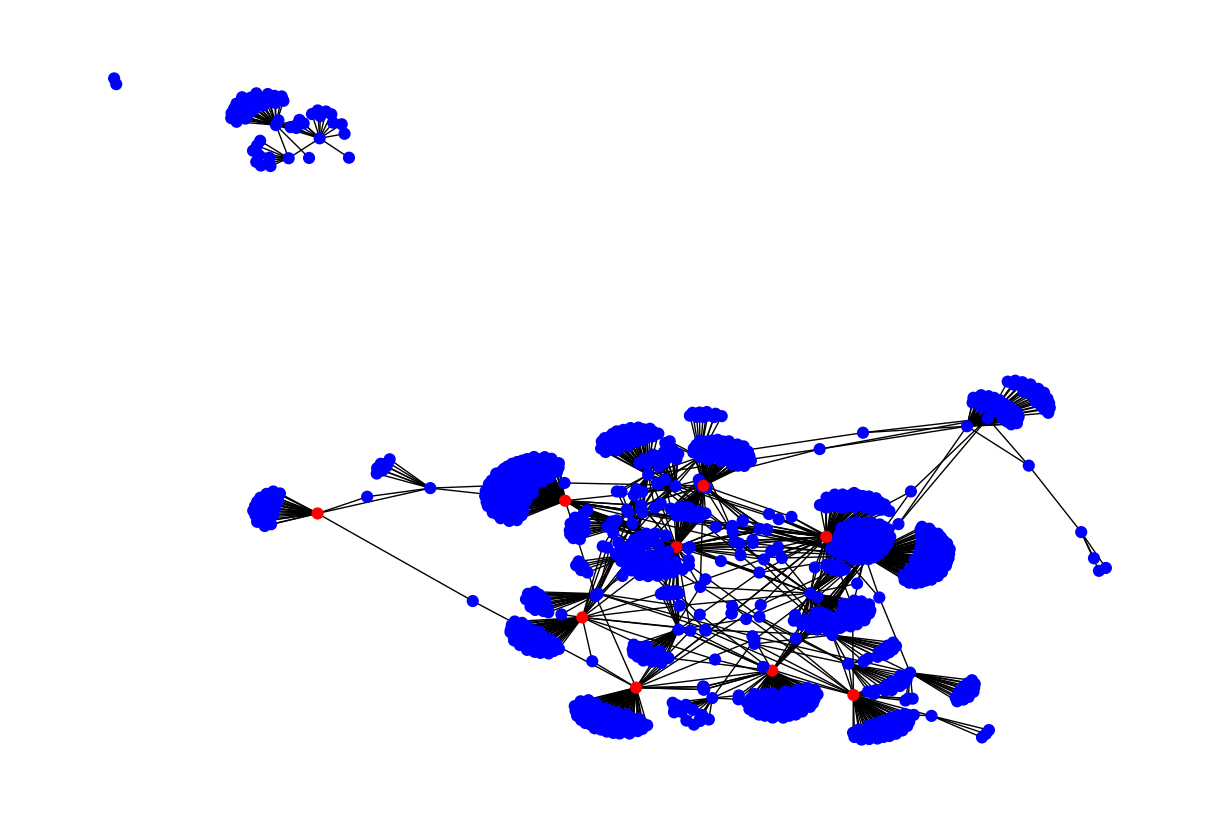

In [9]:
compute_attributes(G)
regression_model = compute_anomaly_scores(G)
visualize_anomalies(G, 10)

In [10]:
# Exercise 2

G1 = nx.random_regular_graph(3, 100)
G2 = nx.connected_caveman_graph(10, 20)

G3 = nx.union(G1, G2, rename=("G1", "G2"))

isolated_nodes = set()
connected_nodes = set()

for node in G3.nodes():
  if len(list(G3.neighbors(node))) == 0:
    isolated_nodes.add(node)
  else:
    connected_nodes.add(node)

# connect random nodes until graph is connected
while len(isolated_nodes) > 0:
  isolated_node = random.choice(list(isolated_nodes))
  connected_node = random.choice(list(connected_nodes))

  G3.add_edge(isolated_node, connected_node, weight=1)

  connected_nodes.add(isolated_node)
  isolated_nodes.remove(isolated_node)

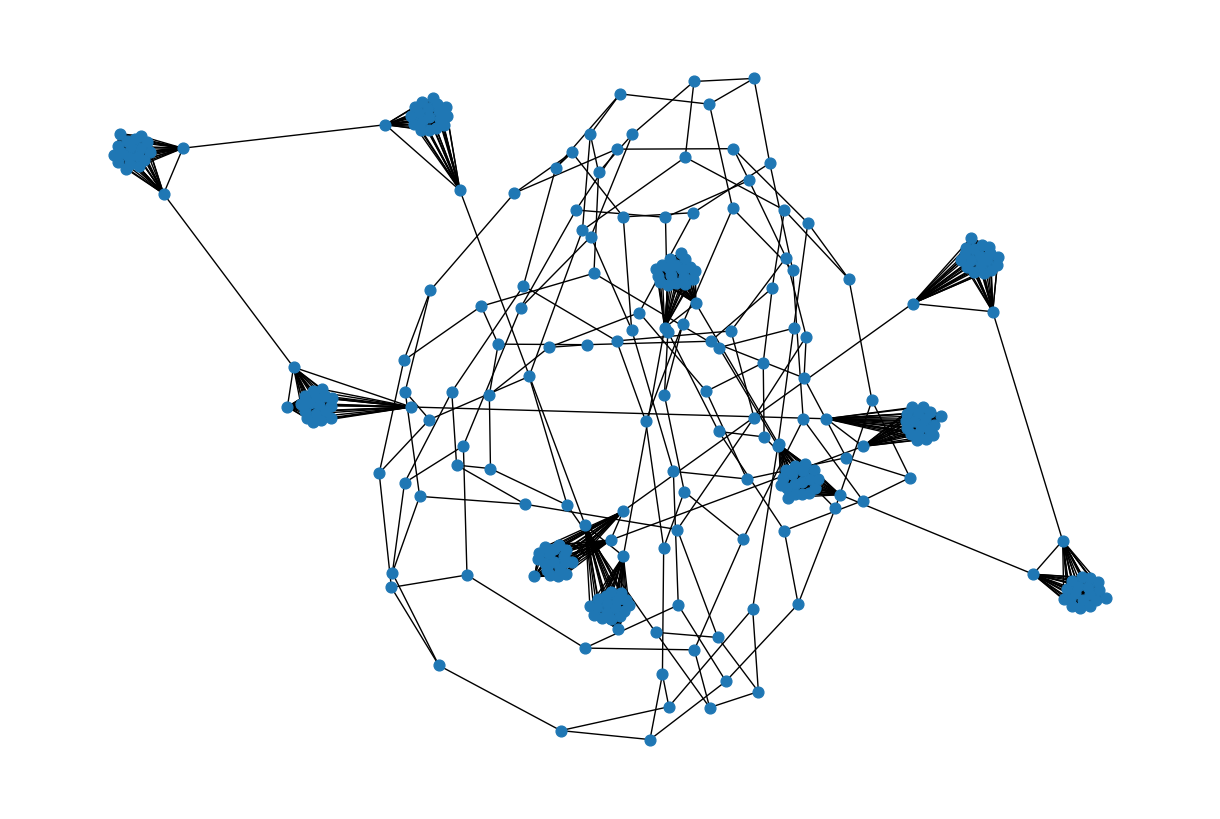

In [11]:
draw_graph(G3)

100%|██████████| 300/300 [00:05<00:00, 59.80it/s]


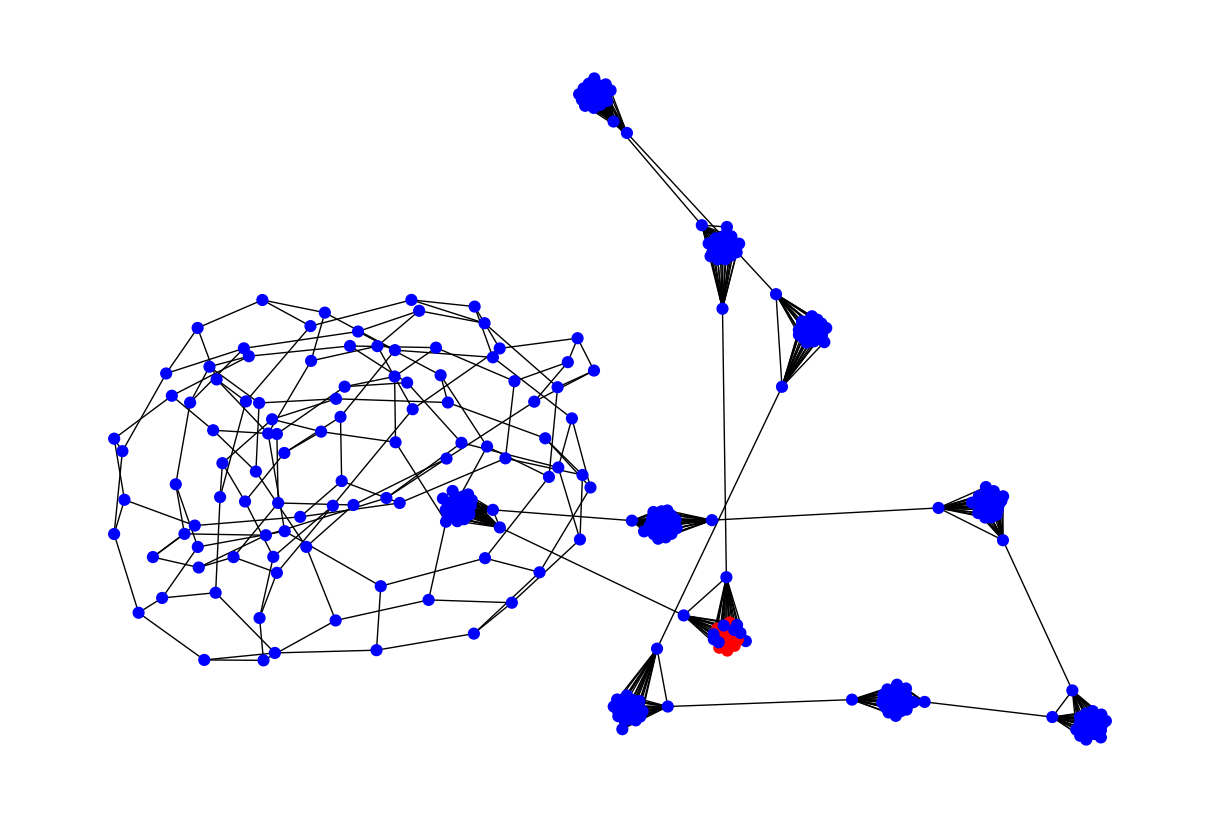

In [12]:
compute_attributes(G3)
compute_anomaly_scores(G3, regression_model)
visualize_anomalies(G3, 10)

In [13]:
G1 = nx.random_regular_graph(3, 100)
G2 = nx.random_regular_graph(5, 100)

G3 = nx.union(G1, G2, rename=("G1", "G2"))

for u, v, d in G3.edges(data=True):
    G3[u][v]['weight'] = 1

# add weight 10 to all neightbours of two random nodes

node1 = random.choice(list(G3.nodes()))
node2 = random.choice(list(G3.nodes()))

for adj in G3[node1]:
  G3[node1][adj]['weight'] += 10

for adj in G3[node2]:
  G3[node2][adj]['weight'] += 10

100%|██████████| 200/200 [00:00<00:00, 259.87it/s]


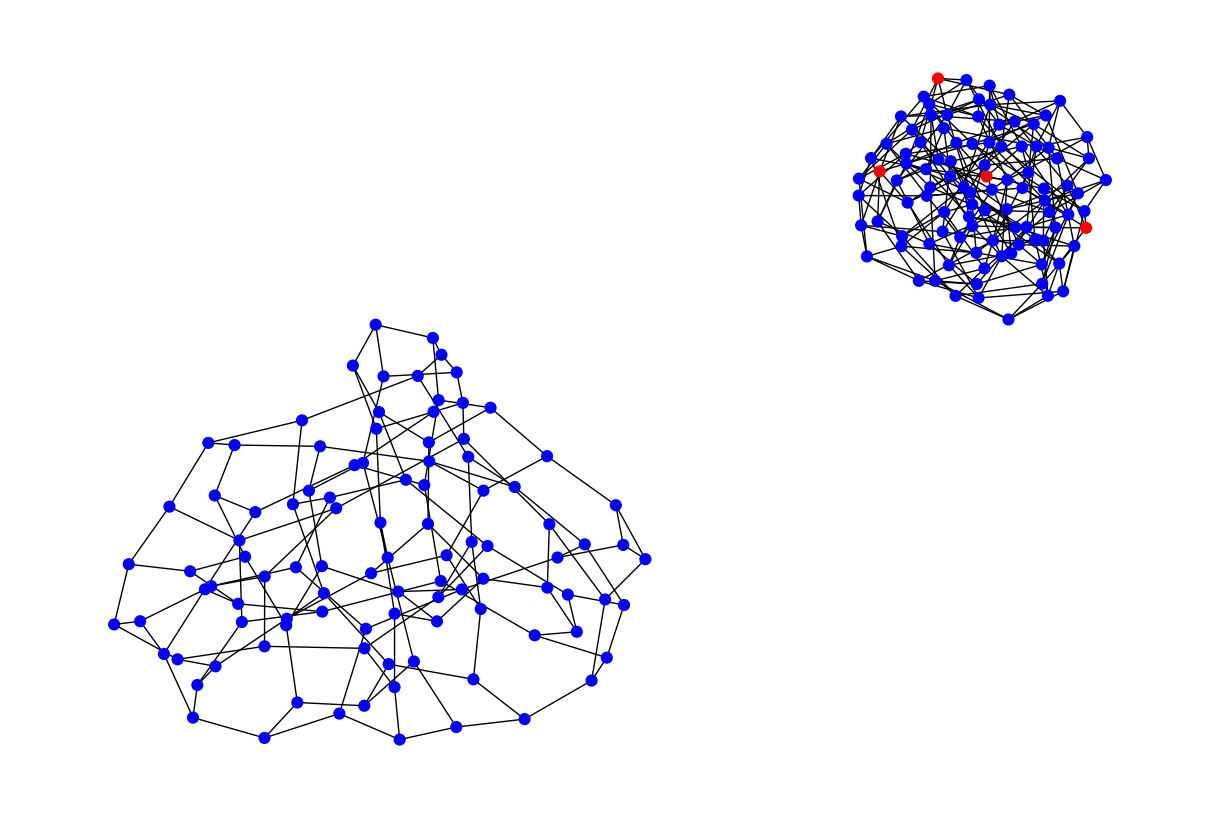

In [14]:
compute_attributes(G3)
compute_anomaly_scores(G3, regression_model)
visualize_anomalies(G3, 4)

In [22]:
# Exercise 3

data = loadmat('ACM.mat')

nodes_attrs = data['Attributes']
adj_mat = from_scipy_sparse_matrix(data['Network'])
node_labels = data['Label']

In [29]:
class EncoderSubmodel(torch.nn.Module):
  def __init__(self, input_dim):
    super(EncoderSubmodel, self).__init__()

    self.conv1 = GCNConv(input_dim, 128)
    self.conv2 = GCNConv(128, 64)

  def forward(self, x, edge_index):
    x = F.relu(self.conv1(x, edge_index))
    x = F.relu(self.conv2(x, edge_index))

    return x

In [30]:
class DecoderSubmodel1(torch.nn.Module):
    def __init__(self, latent_dim):
        super(DecoderSubmodel1, self).__init__()

        self.conv1 = GCNConv(latent_dim, 128)
        self.conv2 = GCNConv(128, latent_dim)

    def forward(self, x, edge_index):
        x = F.relu(self.conv1(x, edge_index))
        x = F.relu(self.conv2(x, edge_index))

        return x

In [31]:
class DecoderSubmodel2(torch.nn.Module):
    def __init__(self):
        super(DecoderSubmodel2, self).__init__()

        self.conv = GCNConv(64, 64)

    def forward(self, x, edge_index):
        x = F.relu(self.conv(x, edge_index))

        adj_pred = torch.matmul(x, x.t())

        return adj_pred

In [33]:
class GraphAutoencoder(torch.nn.Module):
    def __init__(self, input_dim):
        super(GraphAutoencoder, self).__init__()

        self.encoder = EncoderSubmodel(input_dim)
        self.attr_decoder = DecoderSubmodel1(64)
        self.struct_decoder = DecoderSubmodel2()

    def forward(self, x, edge_index):
        z = self.encoder(x, edge_index)
        x_reconstructed = self.attr_decoder(z, edge_index)
        edges_reconstructed = self.struct_decoder(z, edge_index)

        return z, x_reconstructed, edges_reconstructed

In [34]:
def custom_loss_function(X, x_reconstructed, A, A_reconstructed, α=0.8):
    attr_loss = torch.norm(X - x_reconstructed, p='fro')
    edges_loss = torch.norm(A - A_reconstructed, p='fro')

    return α * (attr_loss * attr_loss) + (1 -  α) * (edges_loss * edges_loss)

In [44]:
# model = GraphAutoencoder(64)
# optimizer = torch.optim.Adam(model.parameters(), lr=0.004)

loss_fn = custom_loss_function